# Objective

Following [variance_map_ps.ipynb](variance_map_ps.ipynb), now I try to implement the method given in Appendix A of Planck CO Revisited (Ghosh, S., et al.: A&A, 688, A54).

# Imports and Parameters

In [1]:
from pathlib import Path

import numpy as np
import healpy as hp
from scipy.stats import ks_2samp
from tqdm import tqdm

import matplotlib.pyplot as plt

from handle_data import get_map_dtype, get_planck_obs_data, get_planck_noise_data

In [2]:
DATA_ROOT = "/data/jim/CMB_Data/"
ASSETS_DIRECTORY = f"{DATA_ROOT}/Assets/Planck/"
PLANCK_NOISE_DIR = f"{DATA_ROOT}/Planck_Noise/"

DETECTOR = 100
RANDOM_SEED = 53
PLANCK_SIM_NUM = 0
SMOOTHING = 10 / 60  # 10 arcminutes (in degrees)
BOXCAR_LENGTH = 3
N_WHITE_NOISE_MAPS = 10

In [3]:
def get_lmax_for_nside(nside):
    """Helper function: Max ell for a given nside; to be considered a parameter"""
    return 3 * nside - 1

# Display PS Helpers

In [4]:
def plot_ps(ps,
            title=None, 
            x_low=1,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2,
            log_x=True):
    y_label="$N_{\\ell}(\\mu K^2)$"
    x_label="$\\ell$"
    plt.figure()
    plt.plot(ps)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if log_x:
        plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    plt.show()

In [5]:
def plot_many_ps(ps_s,
            title=None, 
            x_low=1,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2,
            log_x=True,
            labels=None):
    y_label="$N_{\\ell}(\\mu K^2)$"
    x_label="$\\ell$"
    plt.figure()
    for i, ps in enumerate(ps_s):
        label = None if labels is None else labels[i]
        plt.plot(ps, label=label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if log_x:
        plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    plt.legend()
    plt.show()

# Creating a Noise Map at $N_{side}=2048$

We first generate noise as used in CMB-ML for a full resolution map. 

(This section is the same as the other notebook)

In [6]:
obs_map_fn = get_planck_obs_data(detector=DETECTOR, assets_directory=ASSETS_DIRECTORY)
use_nside_out = 2048

File /data/jim/CMB_Data/Assets/Planck/HFI_SkyMap_100_2048_R3.01_full.fits exists.


In [7]:
# Load the source map from Planck
planck_obs_path = Path(ASSETS_DIRECTORY) / obs_map_fn
II_cov_field = 4
II_cov_map = hp.read_map(planck_obs_path, hdu=1, field=II_cov_field)

assert use_nside_out == hp.get_nside(II_cov_map)  # Make sure we're using the right nside

In [8]:
# Create a "scale factor" map for the noise
scale_map = np.sqrt(II_cov_map)  # II_cov_map contains variance values; we need standard deviation for rng.normal()
scale_map = scale_map * 1e6  # convert to uK_CMB

In [9]:
wht_maps = []
wht_cls = []
lmax_2048 = get_lmax_for_nside(use_nside_out)  # Defined above as 3*Nside-1
ells_2048 = np.arange(lmax_2048 + 1)
# Generate the random noise map; calculate its power spectrum
for i in tqdm(range(N_WHITE_NOISE_MAPS)):
    rng = np.random.default_rng(RANDOM_SEED + i)
    wht_maps.append(rng.normal(size=scale_map.shape) * scale_map)
    wht_cls.append(hp.anafast(wht_maps[-1], lmax=lmax_2048))

100%|██████████| 10/10 [03:49<00:00, 23.00s/it]


In [10]:
# hp.mollview(wht_map, unit="$\\mu K_{CMB}$", 
            # title="Aniso White Noise Map" + f" {DETECTOR} GHz, " + "$N_{side}" + f"={use_nside_out}$")

In [11]:
# assert hp.npix2nside(wht_map.shape[0]) == 2048
# print(f"We confirm that the map is resolution {hp.npix2nside(wht_map.shape[0])}")

It looks like white noise at roughly 1e-4 $\mu K^2$.

# Getting Power Spectrum of Sim Noise

I'm trying this out first. It seems like I should be able to apply the method to a single map, as opposed to 5 maps simultaneously. I'm unsure about that though, as the result is not what I'd like.

Method (from Appendix A):
- Get simulation (Sim) with correct anisotropy (not listed as a step in Appendix A)
- Step 1: Generate white noise temperature map (WhT) as above
- Step 2: Smooth WhT to 10' in alm space (WAS)
- Step 3: Compute Cl^TT of WAS (WCl)
- Step 4: Compute Cl^TT of Sim (SCl)
- Step 5: Multiply WAS by SCl^{1/2} * WCl^{-1/2} (element-wise, since these are vectors?)
    - Tried with and without boxcar filter

In [12]:
# Step 0
nse_map_fn = get_planck_noise_data(detector=DETECTOR, assets_directory=ASSETS_DIRECTORY, realization=PLANCK_SIM_NUM)
nse_map = hp.read_map(nse_map_fn) * 1e6
nse_map.shape

File /data/jim/CMB_Data/Assets/Planck/ffp10_noise_100_full_map_mc_00000.fits exists.


(50331648,)

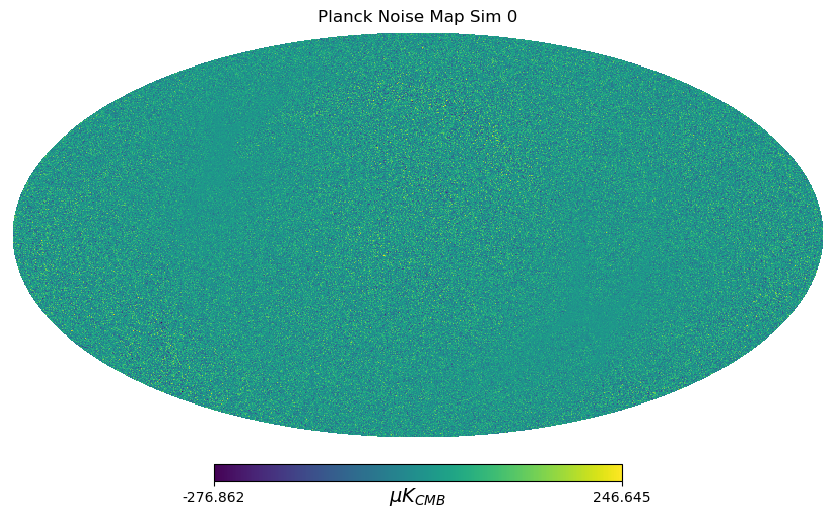

In [13]:
# Plot the loaded map, to ensure there's nothing goofy going on
hp.mollview(nse_map, unit="$\\mu K_{CMB}$", title=f"Planck Noise Map Sim {PLANCK_SIM_NUM}")

In [14]:
# Step 1: Get white noise map - Done above in previous section
#         (Cell is deliberately empty)

In [15]:
# Step 2: Get white noise map in alm domain
wht_alms = [hp.map2alm(wht_map, lmax=lmax_2048) for wht_map in wht_maps]

In [16]:
# Step 3: Get PS of smoothed white noise map
# wht_cl = hp.alm2cl(wht_alm, lmax=lmax_2048, lmax_out=lmax_2048)

In [17]:
# Step 4: Get PS of simulated map
nse_alm = hp.map2alm(nse_map, lmax=lmax_2048)
nse_cl = hp.alm2cl(nse_alm)  # This is for curiosity's sake

In [18]:
# Step 5: Create filter, mulitply alms by filter
def make_filter(boxcar_length, target_cl, source_cl):
    if boxcar_length == 1:
        return np.sqrt(target_cl / source_cl)
    # Noise is white and should be ~constant.
    #    Sometimes the white noise may have very low values in the first few ell bins.
    #    This can cause the filter to be very large in those bins, causing spurious low-ell power.
    #    I'm not sure if it would be better to average these (biased low) or add them (biased high); 
    #    either way these are generally log-scale and we get more reasonable values.
    # source_cl[0] = np.mean(source_cl[0], source_cl.mean())
    # source_cl[1] = np.mean(source_cl[1], source_cl.mean())
    source_cl[0] = source_cl[0] + source_cl.mean()
    source_cl[1] = source_cl[1] + source_cl.mean()
    f = np.sqrt(target_cl / source_cl)
    boxcar = np.ones(boxcar_length)
    f = np.pad(f, (boxcar_length // 2, boxcar_length // 2), mode='edge')
    f = np.convolve(f, boxcar, mode='same') / np.sum(boxcar)
    return f

my_filters_b = [make_filter(BOXCAR_LENGTH, nse_cl, wht_cl) for wht_cl in wht_cls]
out_maps_b = []
out_ps_b = []
for i in range(N_WHITE_NOISE_MAPS):
    out_alm = hp.almxfl(wht_alms[i], my_filters_b[i])
    out_maps_b.append(hp.alm2map(out_alm, nside=use_nside_out, lmax=lmax_2048))
    out_ps_b.append(hp.anafast(out_maps_b[-1], lmax=lmax_2048))

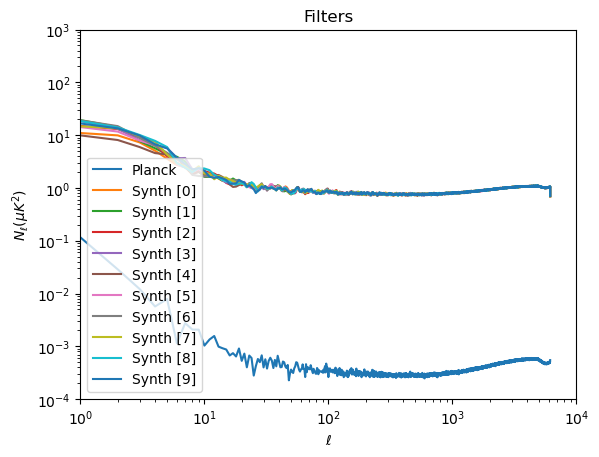

In [19]:
plot_many_ps([
              nse_cl, 
              *my_filters_b
              ], 
              labels=[
                  "Planck", 
                  *[f"Synth [{i}]" for i in range(N_WHITE_NOISE_MAPS)]
                  ],
            #   x_low=-1,
            #   x_high=100,
              y_high=1000,
              title="Filters")

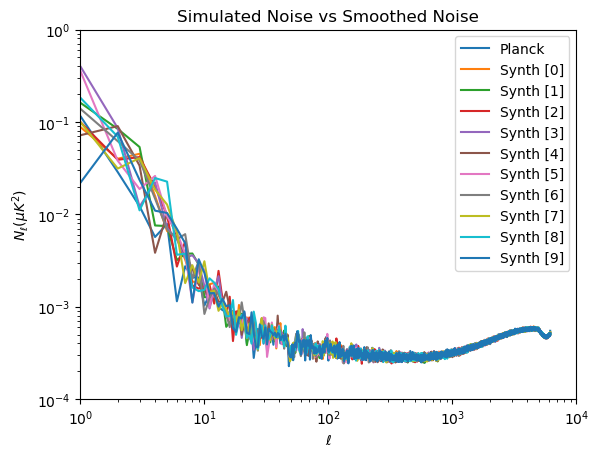

In [20]:
plot_many_ps([
              nse_cl,
              *out_ps_b
              ], 
              labels=[
                  "Planck", 
                  *[f"Synth [{i}]" for i in range(N_WHITE_NOISE_MAPS)]
                  ],
            #   x_low=-1,
            #   x_high=10,
              y_high=1,
              title="Simulated Noise vs Smoothed Noise")

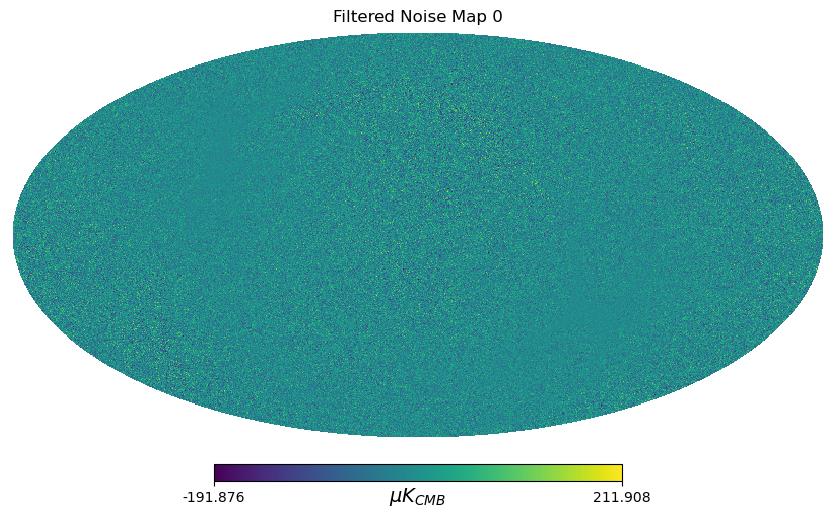

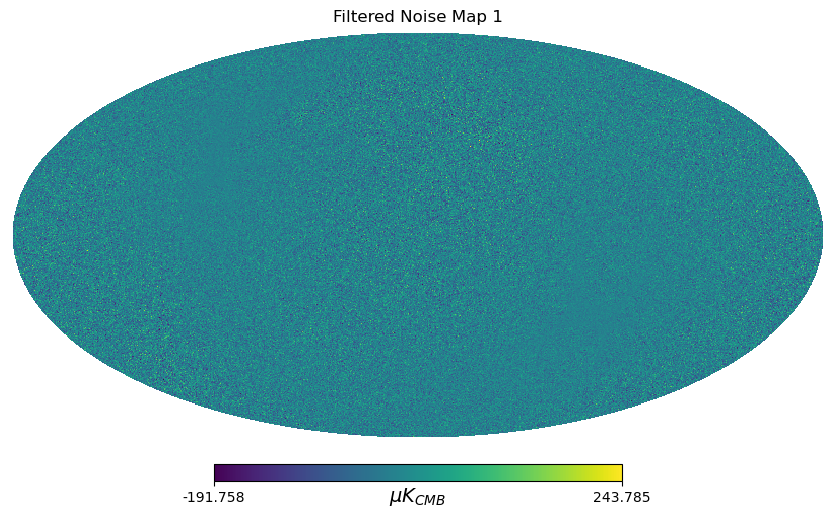

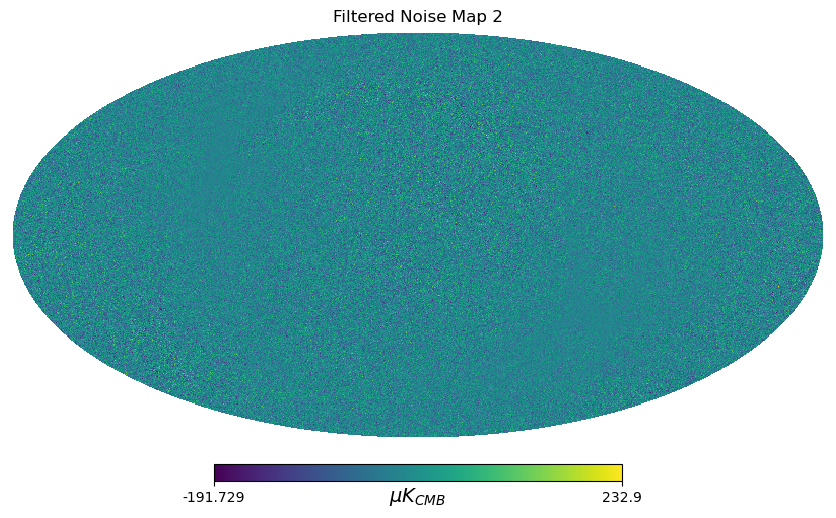

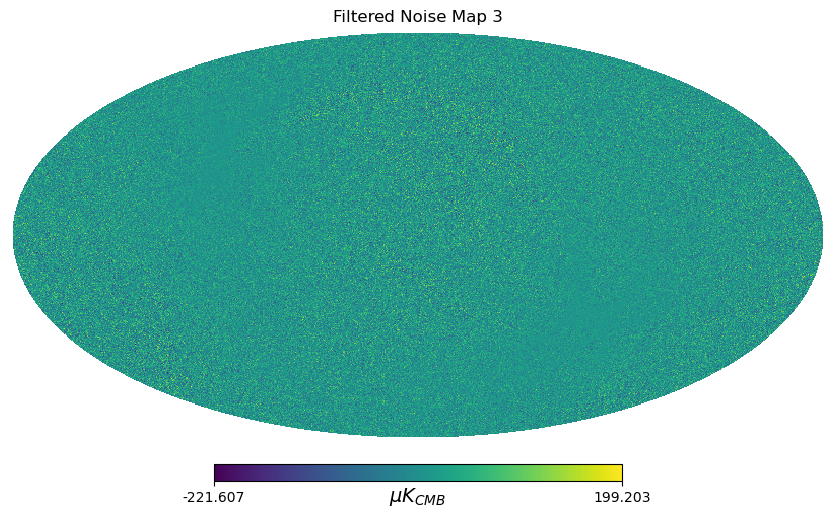

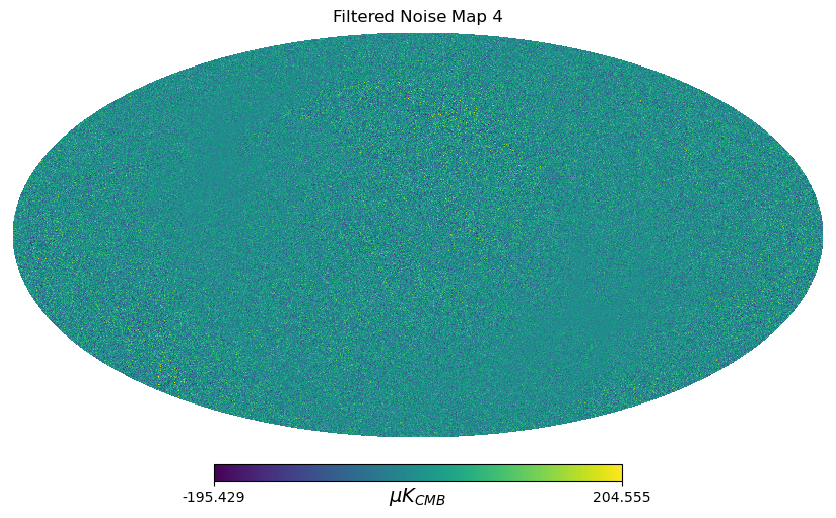

In [21]:
for i in range(5):
    hp.mollview(out_maps_b[i], unit="$\\mu K_{CMB}$", title=f"Filtered Noise Map {i}")

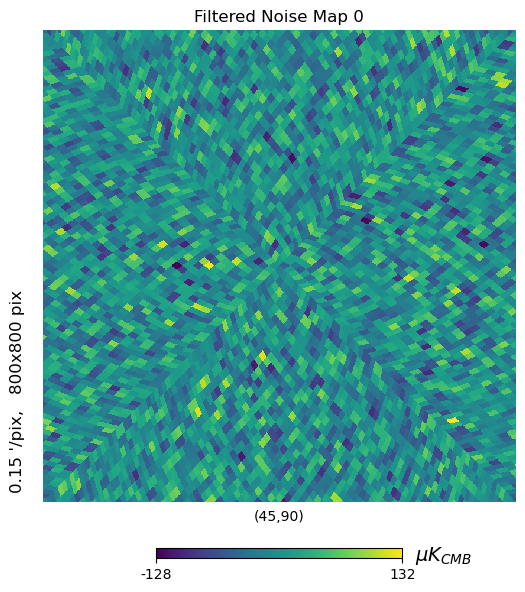

In [34]:
hp.gnomview(out_maps_b[0], rot=[45,90], reso=0.15, xsize=800, ysize=800, unit="$\\mu K_{CMB}$", title="Filtered Noise Map 0")

In [35]:
t_npix = hp.nside2npix(use_nside_out)
full_random = np.random.normal(size=t_npix) * np.std(out_maps_b[0])

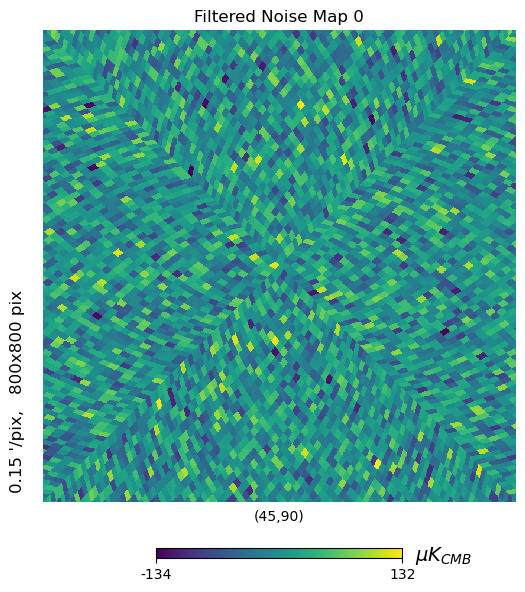

In [36]:
hp.gnomview(full_random, rot=[45,90], reso=0.15, xsize=800, ysize=800, unit="$\\mu K_{CMB}$", title="Filtered Noise Map 0")

In [22]:
my_filters_nb = [make_filter(boxcar_length=1, 
                             target_cl=nse_cl, 
                             source_cl=wht_cl) for wht_cl in wht_cls]
out_maps_nb = []
out_ps_nb = []
for i in range(N_WHITE_NOISE_MAPS):
    out_alm_nb = hp.almxfl(wht_alms[i], my_filters_nb[i])
    out_maps_nb.append(hp.alm2map(out_alm, nside=use_nside_out, lmax=lmax_2048))
    out_ps_nb.append(hp.anafast(out_maps_nb[-1], lmax=lmax_2048))

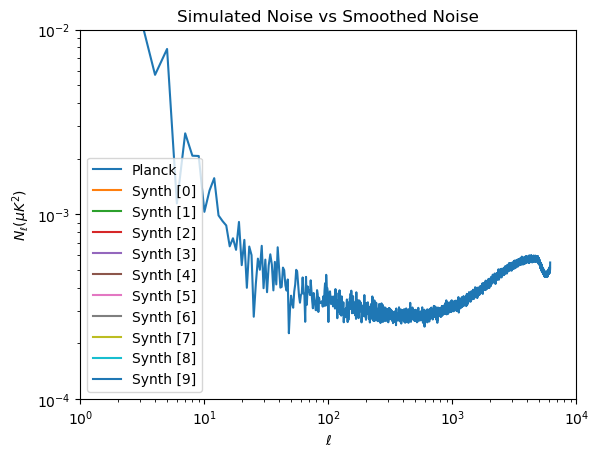

In [23]:
plot_many_ps([
              nse_cl, 
            #   wht_cl, 
              *my_filters_nb
              ], 
              labels=[
                  "Planck", 
                  *[f"Synth [{i}]" for i in range(N_WHITE_NOISE_MAPS)]
                  ],
              # x_low=-1,
              # x_high=10,
              # y_high=1000,
              title="Simulated Noise vs Smoothed Noise")

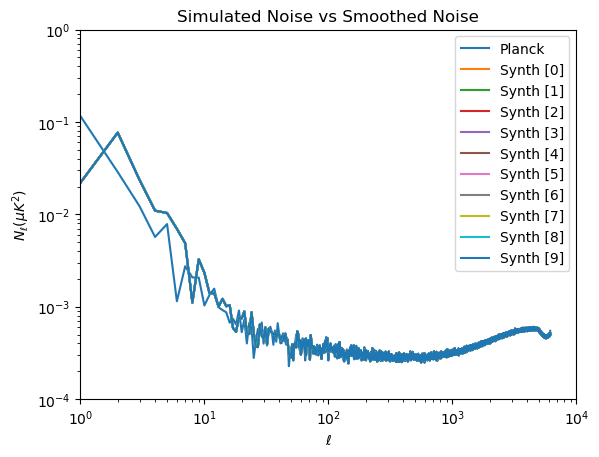

In [24]:
plot_many_ps([
              nse_cl,
            #   wht_cl,
              *out_ps_nb
              ], 
              labels=[
                  "Planck", 
                  *[f"Synth [{i}]" for i in range(N_WHITE_NOISE_MAPS)]
                  ],
              # x_low=-1,
              # x_high=10,
              y_high=1,
              title="Simulated Noise vs Smoothed Noise")

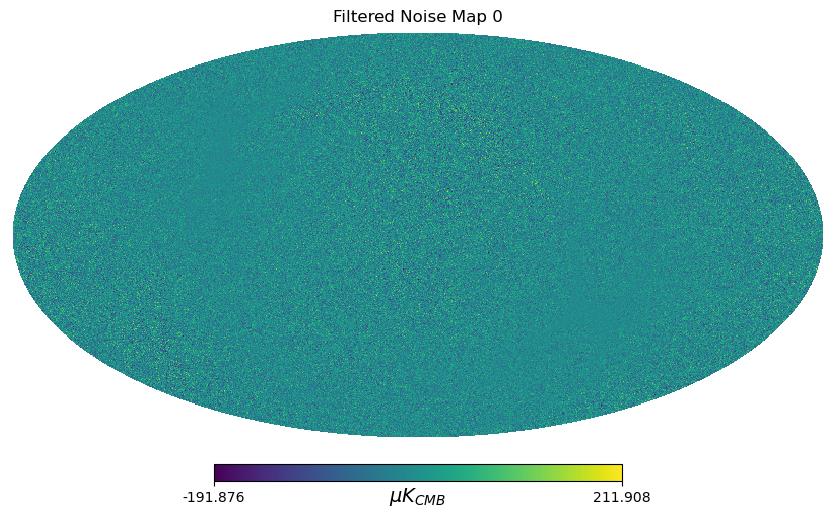

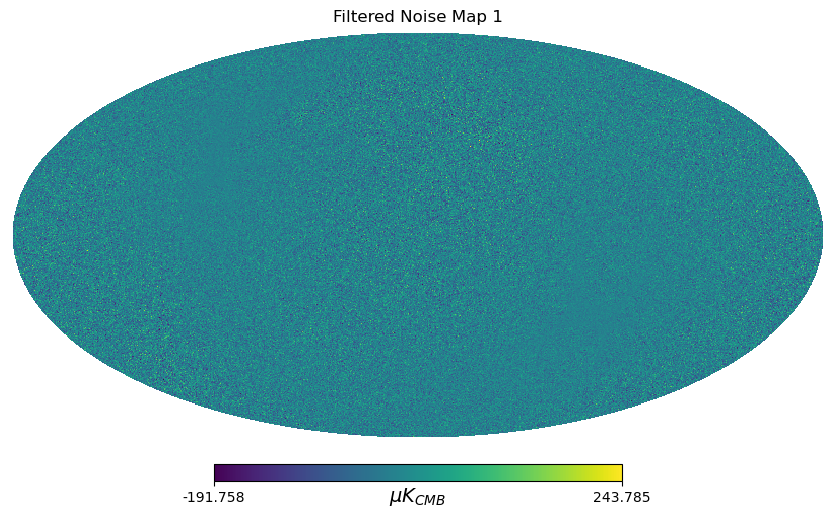

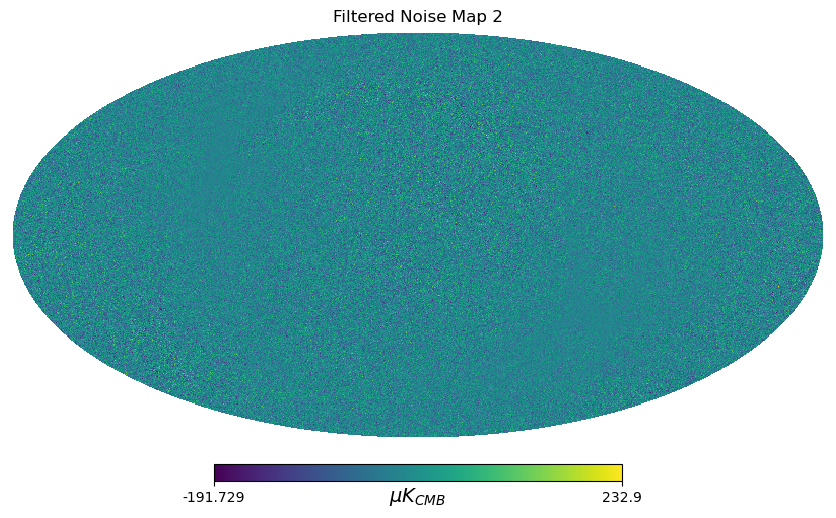

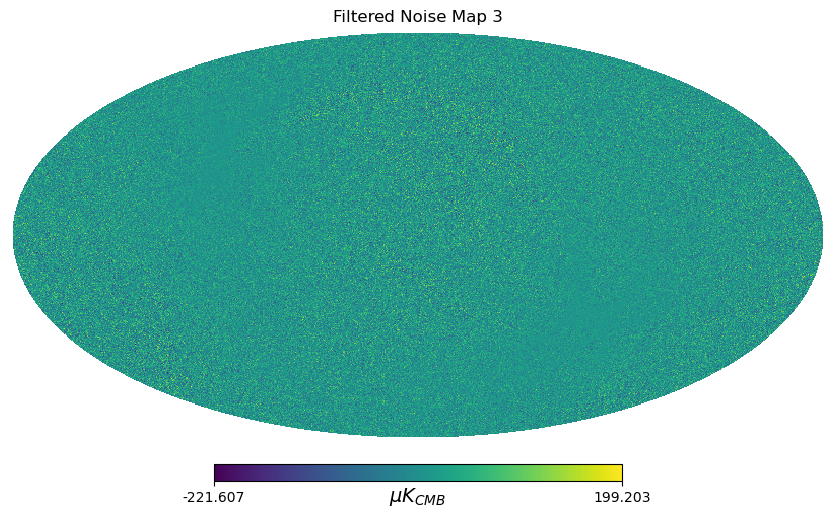

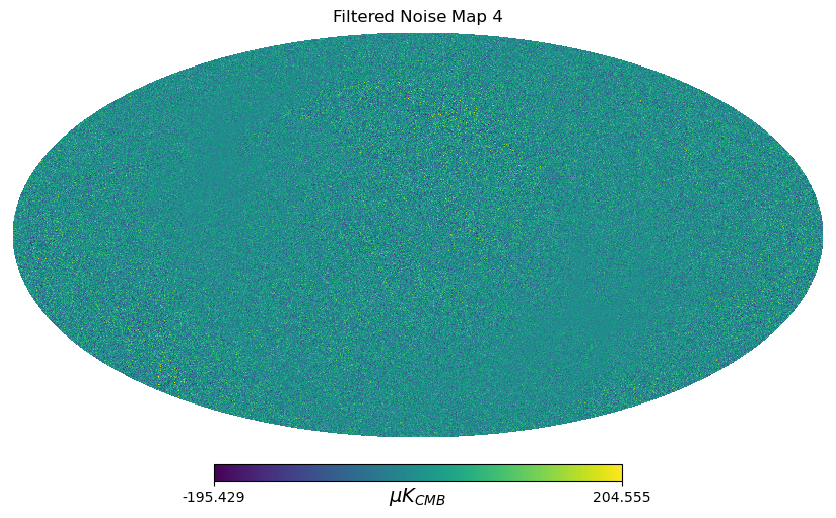

In [25]:
for i in range(5):
    hp.mollview(out_maps_b[i], unit="$\\mu K_{CMB}$", title=f"Filtered Noise Map {i}")